# Calculate subset SHAP values for the 10k cohort patients

## Plain English summary

We will create a "subset SHAP value" for each feature. The 10 features in the model can be classified as either those that are describing the patients characteristics (the “patient descriptive features”) or those that are describing the hospital’s processes (the “hospital descriptive features”). There are eight patient descriptive features (age, stroke severity, prior disability, onset-to-arrival time, stroke type, type of onset time, anticoagulants, and onset during sleep) and there are two hospital descriptive features (arrival-to-scan time, and hospital attended). For this analysis, we only included the single one-hot encoded feature for the attended hospital (and did not include the other 131 one-hot encoded features for the unattended hospitals). We calculated the subset SHAP value for each feature by only including the components of it's SHAP value that exclusively contain the effect from the features in the same subset. This is expressed as the sum of the main effect and the interaction effects with the other features within it’s subset. For the feature “arrival to scan”, which is part of the hospital descriptive subset, its subset SHAP value is the main effect plus the interaction with the feature hospital attended. For each of the features in the patient descriptive subset, its subset SHAP value is the main effect plus the sum of the interactions with each of the other seven patient descriptive features. For each set of descriptive features (hospital and patient) we fitted a multiple regression to predict the hospitals observed thrombolysis rate from the median refined SHAP value of each feature for patients attending each hospital (using values from the all data model).

These values can be compared with the modular/embedded neural network that has a network per subset of features (hospital and patient).

## Model and data

(Use the model as trained in notebook 04)

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 10 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients at their attended hosptial
* Calculate the "subset SHAP values" for each feature

For each patient provide:
* Clinical subset SHAP (total)
* Hospital subset SHAP (total)
* Hospital main SHAP alone
* Total SHAP
* Number of 132 hospitals that would be expected to give the patient thrombolysis (calculated from data saved in notebook 04)

## Observations
* Each unit has a different 'patient threshold' where they are willing to use thrombolysis - a sigmoid distribution.
* The hospital SHAP (that is added to the patient SHAP) decides whether to thrombolyse a patient - pretty normally distributed.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import copy

from scipy import stats

import pickle

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

import math

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '04c'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

Store list of unique stroke teams

In [7]:
hospitals = list(set(train['Stroke team']))
n_hospitals = len(hospitals)

Store list of attended hospital (one per patient)

In [8]:
test_stroke_team = test['Stroke team']

## Fit XGBoost model

Fit or read in XGBoost model on the 10k cohort train/test dataset, and calculate model accuracy.

Save models.

In [9]:
# Fit models (True), or load models (False)
#fit_models = False#True

# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
#X_train_stroke_team = X_train['Stroke team']
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
#X_test_stroke_team = X_test['Stroke team']
X_test.drop('Stroke team', axis=1, inplace=True)    

filename = (f'./saved_models/04_{model_text}.p')
file_exists = exists(filename)

if file_exists:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    # Define model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    # Fit model
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get predicted probabilities and class for 10k cohort
y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
#y_pred = y_prob > 0.5

thrombolysis_rate = []
thrombolysis_rate.append(y_pred.mean())
    
# Save predictions
single_predictions = []
single_predictions.append(y_pred * 1)

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


Calculate receiver operating characteristic curve area under curve.

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.915


## SHAP values and SHAP interactions

### Get SHAP values

Either set up method to estimate SHAP values, or if already created then load from pickle.

In [11]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/04_{model_text}_shap_explainer_'
            f'object.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Get SHAP explainer (using the model and feature values from training set)
    explainer = shap.TreeExplainer(model, X_train)
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

CPU times: user 123 ms, sys: 377 ms, total: 500 ms
Wall time: 45.1 ms


Use this to calculate the SHAP values for the 10k cohort going to their actual hospital (in notebook 04 the 10k cohort were all sent to each of the 132 hospitals - this notebook is different).

In [12]:
%%time

# Use method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/{notebook}_{model_text}_shap_values.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP values
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    # Get SHAP values (using the explainer and feature values from 10k cohort)
    shap_values_extended = explainer(X_test)
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)

CPU times: user 96.9 ms, sys: 243 ms, total: 339 ms
Wall time: 33.6 ms


#### Format the SHAP values data

Features are in the same order in shap_values_extended as they are in the original dataset.

Use this fact to extract the SHAP values for just the one-hot encoded hospital feature of the attended hospital per patient (along with the SHAP values for the other features). 

Create a dataframe containing the SHAP values: an instance per row, and a SHAP value for each feature (with the hosptial feature being the attended hospital's one-hot encoded feature).

In [13]:
#save
#filename = f'./output/{notebook}_{model_text}_SHAP_values.csv'
#file_exists = exists(filename)

#if file_exists:
#    df_hosp_shap_values = pd.read_csv(filename)
#else:

# Get list of hospital one hot encoded column titles
hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospitals_ohe)
# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

# Get list of features not one hot encoded hospital column titles
features_not_hospitals_ohe = list(set(X_test.columns) - set(hospitals_ohe))
# Create list of column index for these feature column titles
features_not_hospitals_ohe_columns_index = (
    [X_test.columns.get_loc(col) for col in features_not_hospitals_ohe])

# Create column titles
columns = copy.deepcopy(features_not_hospitals_ohe)
columns.append("Attended stroke team")

columns

['Stroke severity',
 'Age',
 'Arrival-to-scan time',
 'Precise onset time',
 'Prior disability level',
 'Onset during sleep',
 'Onset-to-arrival time',
 'Infarction',
 'Use of AF anticoagulants',
 'Attended stroke team']

In [14]:
# Initialise empty dataframe with these titles
df_shap_values_attended_hosp = pd.DataFrame(columns=columns)

# For each patient
for row, hosp_attended in zip(shap_values_extended.values,
                              test_stroke_team):
    
    # get column for atteneded hospital
    hospital_column_index = [X_test.columns.get_loc(f"team_{hosp_attended}")]
    

    # Use the index list to access the fatures that aren't hospital shap values
    non_hosp_shap_values = row[features_not_hospitals_ohe_columns_index]
    
    # Put values for features in dataframe with column title
    # Need to put array in dataframe and transpose for it (then convert back to 
    # array) to be added as a row (else put it as a column)
    df_temp = pd.DataFrame(data=pd.DataFrame(non_hosp_shap_values).T.to_numpy(), 
                           columns=features_not_hospitals_ohe)

    # Store the SHAP values for the hospital attended
    df_temp["Attended stroke team"] = row[hospital_column_index]
   

    # Add to master DataFrame
    df_shap_values_attended_hosp = pd.concat(
                            [df_shap_values_attended_hosp, df_temp], axis=0)

# View preview
df_shap_values_attended_hosp.head()

,Stroke severity,Age,Arrival-to-scan time,Precise onset time,Prior disability level,Onset during sleep,Onset-to-arrival time,Infarction,Use of AF anticoagulants,Attended stroke team
0,0.23448,-0.040446,0.497258,-0.301728,0.224214,0.026165,0.316521,-7.214427,-0.84298,0.017261
0,-1.30463,0.004312,0.339406,-1.521458,-0.168006,-1.757024,0.158561,0.811219,-1.204795,-0.618299
0,1.161219,0.107648,1.418404,-0.411153,-0.538457,-1.785861,0.151406,1.014213,0.108413,0.121969
0,0.392636,0.085075,1.356363,0.788107,0.575384,0.038205,0.182026,1.208424,0.14374,1.148519
0,0.906334,-0.043217,1.414243,-0.710574,-0.897133,0.043243,0.621658,0.966015,-1.373795,0.196445


Code used to get SHAP interactions. Needed to set up explainer without X_train. Investigate why later. Gave error "EATURE_DEPENDENCE::independent does not support interactions!" when included X_train in the explainer. Didn't understand the explanations for this error when I googled it. It was raised as an issue for SHAP library.

CODE:

explainer = shap.TreeExplainer(model)#, X_train)
shap_interaction = explainer.shap_interaction_values(X_test)

### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

Use these values to access the main effect for each of the one-hot encoded hospital features.

Either load from pickle (if file exists), or calculate.

#### At the same tiume: Format the SHAP interaction data so only get the main effect for the hospital features

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:
1. contribution from all the hospital features
2. contribution from attending the hospital
3. contribution from not attending the rest

SHAP interaction values have a matrix of values (per pair of features) per instance.

For each hospital, have the 10k instances each with a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

Once get the SHAP interaction values, calculate the subset SHAP values. This is the main effect + interactions with the features int he same subset (hospital, or patient)

In [15]:
%%time

filename = f'./output/{notebook}_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction array
    with open(filename, 'rb') as filehandler:
        shap_interactions = pickle.load(filehandler)
else:
    explainer = shap.TreeExplainer(model)#, X_train)

    # Get SHAP values (along with base and feature values)
    shap_interactions = explainer.shap_interaction_values(X_test)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interactions, filehandler) 

CPU times: user 6.74 ms, sys: 303 ms, total: 310 ms
Wall time: 832 ms


In [16]:
col_names = list(X_test.columns)
col_names[:10]

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'team_AGNOF1041H']

### Define the features in each subset

Have two subsets: patient and hosptial

In [17]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

In [18]:
hospital_features = ['Arrival-to-scan time','Stroke team']

In [19]:
%%time

# get indices for the hospitals
hospitals_indices = [col_names.index(h) for h in hospitals_ohe]

# create list (one per value type) with features as column title
shap_values_without_unattended_hosp = []
shap_main_effects = []
shap_interactions_within_subgroup = []
shap_interactions_across_subgroups = []
shap_main_effects_and_within_interactions = []

# work through each patients shap interaction matrix
for p in range(shap_interactions.shape[0]):

    # get shap interactions for a patient
    si = shap_interactions[p]

    # get hospital the patient attends
    attend = test_stroke_team[p]
    
    # get column index for hosptial attend
    hospital_keep_index = [col_names.index(f'team_{attend}')]

    # get indices for the other hosptials (those not attend) to remove for 
    #   this patient
    hospitals_remove_indices = list(set(hospitals_indices) - 
                                    set(hospital_keep_index))
    
    # delete the rows and columns in the shap interaction matrix for the 
    #   hospitals not attended
    shap_interaction_attendhosp = np.delete(si, hospitals_remove_indices, 0)
    shap_interaction_attendhosp = np.delete(shap_interaction_attendhosp, 
                                            hospitals_remove_indices, 1)

    # and remove the not attended hospitals from the column names
    col_names_attendhosp = np.delete(col_names, hospitals_remove_indices, 0)

    # rename the one hosptial left with the generic "Stroke team" name
    col_names_attendhosp = np.char.replace(col_names_attendhosp, 
                                           f'team_{attend}', "Stroke team")
    
    # number of features in the resulting shap interaction matrix
    n_si_features = shap_interaction_attendhosp.shape[0]

    # get the indices for the features in each multiple regression
    patient_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                               for f in patient_features]
    hospital_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                                for f in hospital_features]
    
    # calculate the different feature values
    # 1. SHAP values (without any contribution from hospital not attended)
    shap_values = shap_interaction_attendhosp.sum(axis=1)

    # add to list (entry per patient containing value per feature)
    shap_values_without_unattended_hosp.append(shap_values)

    # 2. main effect value for each of the features
    main_effects = np.diagonal(shap_interaction_attendhosp)

    # add to list (entry per patient contianing value per feature)
    shap_main_effects.append(main_effects)
    
    # 3. SHAP interactions within feature subgroup (patient, hospital)
    list_of_list = [patient_features_col_id,
                    hospital_features_col_id]

    # initialise a zero array with size of number of features (excluding 
    #   unattended hostpial)
    within_subgroup_array = np.zeros((n_si_features))
    # Through a list of subgroup features at a time
    for features_col_ids in list_of_list: 
        # Through features in subgroup
        for f1 in features_col_ids:
            # Take a deep copy of all of the features
            remaining = copy.deepcopy(features_col_ids)
            # Remove the current feature (get a list of the other features in 
            #   the subgroup
            remaining.remove(f1)
            # Initialise a variable to sum the interactions that are with
            #   features from the same subgroup
            sum_elements = 0
            # Through the other features in the subgroup
            for f2 in remaining:
                sum_elements += shap_interaction_attendhosp[f1, f2]
            # Store summed interactions in the array
            within_subgroup_array[f1] = sum_elements
    
    # add to list (entry per patient contianing value per feature)
    shap_interactions_within_subgroup.append(within_subgroup_array)
    
    # 4. SHAP interactions outside feature subgroup
    across_subgroups_array = np.zeros((n_si_features))

    # Through patient subgroup features
    for f1 in patient_features_col_id:
        # Initialise variable to sum the interactions that are with
        #   features from the different subgroup
        sum_elements = 0
        # Through the features in the other subgroup
        for f2 in hospital_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        # Store summed interactions in the array
        across_subgroups_array[f1] = sum_elements

    # Through patient subgroup features
    for f1 in hospital_features_col_id:
        # Initialise variable to sum the interactions that are with
        #   features from the different subgroup
        sum_elements = 0
        # Through the features in the other subgroup
        for f2 in patient_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        # Store summed interactions in the array
        across_subgroups_array[f1] = sum_elements

    # add to list (entry per patient contianing value per feature)
    shap_interactions_across_subgroups.append(across_subgroups_array)

    # 5. main effect + SHAP interaction within: sum array (2) + (3)
    main_effect_and_within = main_effects + within_subgroup_array
    
    # add to list (entry per patient contianing value per feature)
    shap_main_effects_and_within_interactions.append(main_effect_and_within)
    
# put lists into dataframe, with features as column title
df_hosp_shap_values_without_unattended_hosp = (
                        pd.DataFrame(shap_values_without_unattended_hosp, 
                                     columns=col_names_attendhosp))
df_hosp_shap_main_effects = (
                        pd.DataFrame(shap_main_effects, 
                                     columns=col_names_attendhosp))
df_hosp_shap_interactions_within = (
                        pd.DataFrame(shap_interactions_within_subgroup, 
                                     columns=col_names_attendhosp))
df_hosp_shap_interactions_outside = (
                        pd.DataFrame(shap_interactions_across_subgroups, 
                                     columns=col_names_attendhosp))
df_hosp_shap_main_effects_and_within_interactions = (
                        pd.DataFrame(shap_main_effects_and_within_interactions, 
                                     columns=col_names_attendhosp))

CPU times: user 3.62 s, sys: 34 ms, total: 3.65 s
Wall time: 3.63 s


In [20]:
df_hosp_shap_main_effects_and_within_interactions

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Stroke team
0,0.344768,-8.024301,-0.143781,-0.443354,0.180350,-0.795312,0.198188,0.034327,-0.012963,-0.148998
1,-0.146492,0.180547,-1.639628,-0.867942,-0.407695,-1.185268,0.084938,-1.406218,-0.022495,0.266283
2,0.869757,0.297213,0.786024,-0.949098,-0.611850,0.151533,-0.030462,-1.601547,0.116776,-0.292496
3,0.883030,0.434410,0.201015,0.469563,0.414798,0.185233,0.121663,0.039728,0.063495,0.902912
4,0.883407,0.239610,0.455630,-0.762424,-0.778811,-1.276674,0.438555,0.052786,-0.170120,0.005039
...,...,...,...,...,...,...,...,...,...,...
9995,0.857083,0.214481,-0.298851,-0.805878,-0.458450,-1.594497,-0.409960,0.045033,-0.424924,-0.671811
9996,0.037697,0.219542,-2.275019,-0.609995,0.320527,0.145350,0.053685,0.047866,0.131290,-0.945354
9997,1.000820,0.372444,0.739026,-0.959546,0.423563,0.161873,0.025115,0.082223,0.130244,0.958532
9998,0.650933,0.269002,-1.765828,0.372576,0.315834,0.124963,-0.015693,0.037125,0.167809,0.047880


In [21]:
df_hosp_shap_main_effects_and_within_interactions.columns

Index(['Arrival-to-scan time', 'Infarction', 'Stroke severity',
       'Precise onset time', 'Prior disability level',
       'Use of AF anticoagulants', 'Onset-to-arrival time',
       'Onset during sleep', 'Age', 'Stroke team'],
      dtype='object')

In [22]:
df_SHAP_output = pd.DataFrame()

# Clinical subset SHAP (total)
df_SHAP_output["patient_subset_total"] = (
 df_hosp_shap_main_effects_and_within_interactions[patient_features].sum(axis=1))

# Hospital subset SHAP (total)
df_SHAP_output["hospital_subset_total"] = (
 df_hosp_shap_main_effects_and_within_interactions[hospital_features].sum(axis=1))

# Hospital main SHAP alone
df_SHAP_output["hospital_main_shap"] = (df_hosp_shap_main_effects["Stroke team"])
 
# Sum of the features SHAP values
df_SHAP_output["sum_of_feature_shap_values"] = shap_values_extended.values.sum(axis=1)

# SHAP base value
df_SHAP_output["shap_base_value"] = shap_values_extended.base_values

# Total SHAP
df_SHAP_output["total_shap_value"] = (
                                df_SHAP_output["sum_of_feature_shap_values"] + 
                                df_SHAP_output["shap_base_value"])
df_SHAP_output.head()

,patient_subset_total,hospital_subset_total,hospital_main_shap,sum_of_feature_shap_values,shap_base_value,total_shap_value
0,-9.006844,0.195771,-0.150145,-7.111710,-2.945368,-10.057078
1,-5.263762,0.119791,0.266337,-5.373571,-2.945368,-8.318939
2,-1.841411,0.577261,-0.386164,1.244765,-2.945368,-1.700603
3,1.929906,1.785942,0.870760,5.908253,-2.945368,2.962885
4,-1.801448,0.888446,0.053796,1.020495,-2.945368,-1.924873


Read in data about number of hosptials that give each patient IVT

In [23]:
filename = (f'./output/04_{model_text}_individual_predictions.csv')
patient_ivt_rate_10k = pd.read_csv(filename)

Add that data to the dataframe

In [24]:
# Number hospitals expect to use thrombolysis on each patient
df_SHAP_output["n_hospitals_give_ivt"] = patient_ivt_rate_10k.sum(axis=1)
df_SHAP_output.head()

,patient_subset_total,hospital_subset_total,hospital_main_shap,sum_of_feature_shap_values,shap_base_value,total_shap_value,n_hospitals_give_ivt
0,-9.006844,0.195771,-0.150145,-7.111710,-2.945368,-10.057078,0
1,-5.263762,0.119791,0.266337,-5.373571,-2.945368,-8.318939,0
2,-1.841411,0.577261,-0.386164,1.244765,-2.945368,-1.700603,1
3,1.929906,1.785942,0.870760,5.908253,-2.945368,2.962885,123
4,-1.801448,0.888446,0.053796,1.020495,-2.945368,-1.924873,1


Save file

In [25]:
filename = f'./output/{notebook}_{model_text}_subset_shap_values.csv'
df_SHAP_output.to_csv(filename)

Bin by patient SHAP (0.5 width bins) and show the average number of the number of hospitals that would give each patient thrombolysis in that bin.

In [26]:
st = round(min(df_SHAP_output["patient_subset_total"]) * 2) / 2
ed = round(max(df_SHAP_output["patient_subset_total"]) * 2) / 2
bins = np.arange(st, ed, 0.5).tolist()

cuts = pd.cut(df_SHAP_output["patient_subset_total"], bins)

df = (df_SHAP_output.groupby([cuts]).n_hospitals_give_ivt.mean()).reset_index(
                                                    name='avg_hosp_give_ivt')

df1 = (df_SHAP_output.groupby([cuts]).n_hospitals_give_ivt.std()).reset_index(
                                    name='std_hosp_give_ivt')

df['std_hosp_give_ivt'] = df1['std_hosp_give_ivt']
df.head()

,patient_subset_total,avg_hosp_give_ivt,std_hosp_give_ivt
0,"(-12.0, -11.5]",0.0,NaN
1,"(-11.5, -11.0]",0.0,0.0
2,"(-11.0, -10.5]",0.0,0.0
3,"(-10.5, -10.0]",0.0,0.0
4,"(-10.0, -9.5]",0.0,0.0


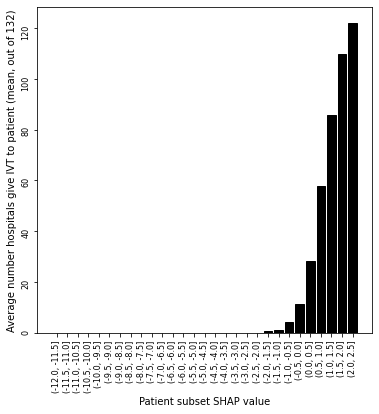

In [27]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.bar(df['patient_subset_total'].astype(str), df['avg_hosp_give_ivt'], 
       edgecolor='k', facecolor='k')
ax.set_xlabel('Patient subset SHAP value')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Average number hospitals give IVT to patient (mean, out of 132)')

plt.savefig(
        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
        f'hospitals_give_ivt_bar.jpg', 
        dpi=300)

plt.show()

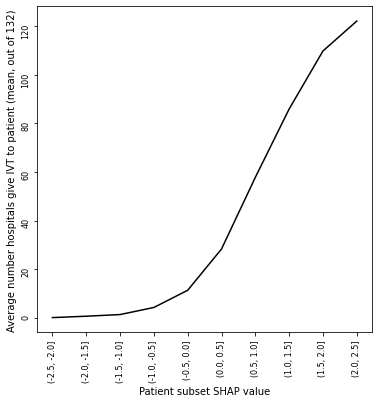

In [28]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plt.plot(df.iloc[19:]['patient_subset_total'].astype(str), 
         df.iloc[19:]['avg_hosp_give_ivt'],
        'k')
ax.set_xlabel('Patient subset SHAP value')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Average number hospitals give IVT to patient (mean, out of 132)')

plt.savefig(
        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
        f'hospitals_give_ivt_line.jpg', 
        dpi=300)

plt.show()

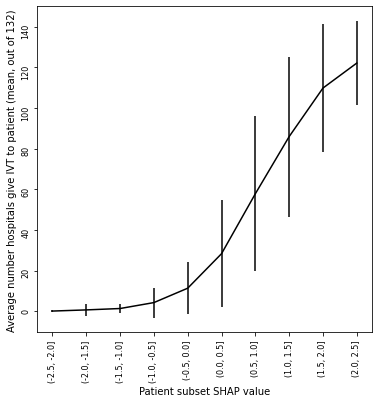

In [29]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plt.errorbar(df.iloc[19:]['patient_subset_total'].astype(str), 
             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df.iloc[19:]['std_hosp_give_ivt'],
             color='k')

ax.set_xlabel('Patient subset SHAP value')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Average number hospitals give IVT to patient (mean, out of 132)')

plt.savefig(
        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
        f'hospitals_give_ivt_line_std_errorbars.jpg', 
        dpi=300)

plt.show()



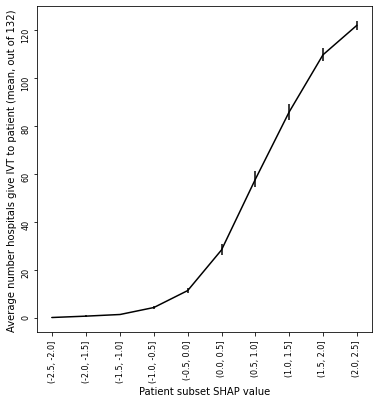

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
plt.errorbar(df.iloc[19:]['patient_subset_total'].astype(str), 
             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df.iloc[19:]['std_hosp_give_ivt']/math.sqrt(n_hospitals),
             color='k')

ax.set_xlabel('Patient subset SHAP value')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Average number hospitals give IVT to patient (mean, out of 132)')

plt.savefig(
        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
        f'hospitals_give_ivt_line_sem_errorbars.jpg', 
        dpi=300)

plt.show()


### Check SHAP == y_prob

In [31]:
df_SHAP_output["y_prob"] = y_prob 
df_SHAP_output["y_prob_to_log_odds"] = np.log(y_prob /(1 - y_prob))
df_SHAP_output[['total_shap_value', 'y_prob_to_log_odds']].head()

,total_shap_value,y_prob_to_log_odds
0,-10.057078,-10.057077
1,-8.318939,-8.318940
2,-1.700603,-1.700603
3,2.962885,2.962885
4,-1.924873,-1.924872
